In [2]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import scipy as sp
from scipy import sparse
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from openTSNE import TSNE
from openTSNE import affinity, initialization, TSNEEmbedding
from openTSNE.affinity import Affinities

import time
import pickle

import memory_profiler
%load_ext memory_profiler

from pathlib import Path

In [2]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [3]:
variables_path = Path('../results/variables')
figures_path = Path('../results/figures')
berenslab_data_path = Path('/gpfs01/berens/data/data/pubmed_processed')

In [5]:
plt.style.use("matplotlib_style.txt")

Pipeline from raw text to two dimensional embedding

# Import

In [3]:
# import clean_df_updated
clean_df_updated_reparsed_filtered_with_authors_ISSN=pd.read_pickle(berenslab_data_path / "clean_df_updated_reparsed_filtered_with_authors_ISSN")

In [4]:
#save df
clean_df_updated_reparsed_filtered_with_authors_ISSN.to_pickle(variables_path / "clean_df_updated_reparsed_filtered_with_authors_ISSN")

In [4]:
clean_df_updated_reparsed_filtered_with_authors_ISSN.shape

(20687150, 7)

# TF-IDF Vectorizer

In [ ]:
%%time
%%memit

# TfidfVectorizer
corpus = clean_df_updated_reparsed_filtered_with_authors_ISSN['AbstractText'].tolist()
vectorizer = TfidfVectorizer(sublinear_tf=True)
tfidf_features_updated_reparsed = vectorizer.fit_transform(corpus)

In [10]:
print(tfidf_features_updated_reparsed.shape)

(20687150, 4679130)


In [ ]:
#save results
sp.sparse.save_npz(variables_path / "tfidf_features_updated_reparsed", tfidf_features_updated_reparsed)

In [ ]:
vocabulary_updated_reparsed=vectorizer.vocabulary_

#save results
f = open(variables_path / "vocabulary_updated_reparsed.pkl","wb")
pickle.dump(vocabulary_updated_reparsed,f)
f.close()

# Truncated SVD

In [4]:
#  results
tfidf_features_updated_reparsed = sp.sparse.load_npz(variables_path / "tfidf_features_updated_reparsed.npz")

tcmalloc: large alloc 18038185984 bytes == 0x5af2000 @ 
tcmalloc: large alloc 18038185984 bytes == 0x43a030000 @ 


In [5]:
tfidf_features_updated_reparsed.data.shape

(2254772707,)

In [6]:
tfidf_features_updated_reparsed.shape

(20687150, 4679130)

In [7]:
2254772707/(20687150*4679130)*100

0.0023293620433802085

In [5]:
%%time
%%memit

#TruncatedSVD
svd = TruncatedSVD(n_components=300,random_state=42,algorithm='arpack')
svd_data_updated_reparsed=svd.fit_transform(tfidf_features_updated_reparsed)

# save results
np.save(variables_path / "svd_data_updated_reparsed",svd_data_updated_reparsed)

peak memory: 254752.98 MiB, increment: 219918.09 MiB
CPU times: user 18h 59min 7s, sys: 8h 13min 37s, total: 1d 3h 12min 44s
Wall time: 5h 35min 57s


# t-SNE

Annealing exgg=1, n_iter=2000 

In [2]:
svd_data_updated_reparsed = np.load(variables_path / "svd_data_updated_reparsed.npy")

## Affinities

In [3]:
%%time
%%memit

A = affinity.Uniform(svd_data_updated_reparsed, k_neighbors=10, n_jobs=-1, verbose=1, random_state=42)

===> Finding 10 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 3900.45 seconds
peak memory: 176611.82 MiB, increment: 128887.51 MiB
CPU times: user 9h 32min 15s, sys: 4h 14min 10s, total: 13h 46min 26s
Wall time: 1h 6min 17s


In [4]:
#save results
sp.sparse.save_npz(variables_path / "affinities_P_tfidf_reparsed", A.P)

True

In [ ]:
# load affinities P
# affinities_P_tfidf_reparsed = sp.sparse.load_npz(variables_path / "affinities_P_tfidf_reparsed.npz")

In [ ]:
# create the affinities object

#A = Affinities()
#A.P = affinities_P_tfidf_reparsed#.tocsr()

## Initialization

In [5]:
%%time
%%memit

I = initialization.pca(svd_data_updated_reparsed, random_state=42)

np.save(variables_path / "initialization_tfidf_reparsed", I)

peak memory: 272429.91 MiB, increment: 96455.09 MiB
CPU times: user 21min 36s, sys: 13min 2s, total: 34min 39s
Wall time: 3min 45s


In [6]:
# I=np.load(variables_path / "initialization.npy")

## Optimization

In [6]:
Zs = []
kls = []
n_iter = []

def mycallback(iteration, error, embedding):
    Zs.append(embedding.copy())
    kls.append(error)
    n_iter.append(iteration)

In [7]:
%%capture cap

E = TSNEEmbedding(I, A, n_jobs=-1, random_state=42, verbose=True)

# early exaggeration
E = E.optimize(n_iter=125, exaggeration=12, momentum=0.5, n_jobs=-1, verbose=True, callbacks=mycallback, callbacks_every_iters=50)

# exaggeration annealing
exs = np.linspace(12,1,125)
for i in range(125):
    if (i+1)%50 == 0:
        E = E.optimize(n_iter=1, exaggeration=exs[i], momentum=0.8, n_jobs=-1, verbose=True, callbacks=mycallback, callbacks_every_iters=1)
        
    else:
        E = E.optimize(n_iter=1, exaggeration=exs[i], momentum=0.8, n_jobs=-1, verbose=True)
    
# final optimization without exaggeration
E = E.optimize(n_iter=2000, exaggeration=1, momentum=0.8, n_jobs=-1, verbose=True, callbacks=mycallback, callbacks_every_iters=50)

In [8]:
with open(variables_path / 'verbose_tsne_tfidf_reparsed.txt', 'w') as f:
    f.write(cap.stdout)

In [9]:
Zs_array=[]
for i in np.arange(len(Zs)):
    Zs_array.append(np.array(Zs[i]))

In [10]:
#save results
f = open(variables_path / "Zs_array_tfidf_reparsed.pkl","wb")
pickle.dump(Zs_array,f)
f.close()

In [11]:
#load
# pickle_in = open(variables_path / "Zs_array_tfidf_reparsed.pkl","rb")
# Zs_array = pickle.load(pickle_in)

In [12]:
#save iter
f = open(variables_path / "iterations_tfidf_reparsed.pkl","wb")
pickle.dump(n_iter,f)
f.close()

In [13]:
# #load
# pickle_in = open(variables_path / "iterations.pkl","rb")
# iterations = pickle.load(pickle_in)

In [14]:
#save kl divergence
f = open(variables_path / "kl_divergence_tfidf_reparsed.pkl","wb")
pickle.dump(kls,f)
f.close()

In [15]:
# #load
# pickle_in = open(variables_path / "kl_divergence.pkl","rb")
# kls = pickle.load(pickle_in)

In [16]:
tsne_tfidf_reparsed=np.array(E)

#save
np.save(variables_path / "tsne_tfidf_reparsed", tsne_tfidf_reparsed)

In [2]:
tsne_tfidf_reparsed=np.load(variables_path / "tsne_tfidf_reparsed.npy")

In [3]:
tsne_tfidf_reparsed.shape

(20687150, 2)

# Plot

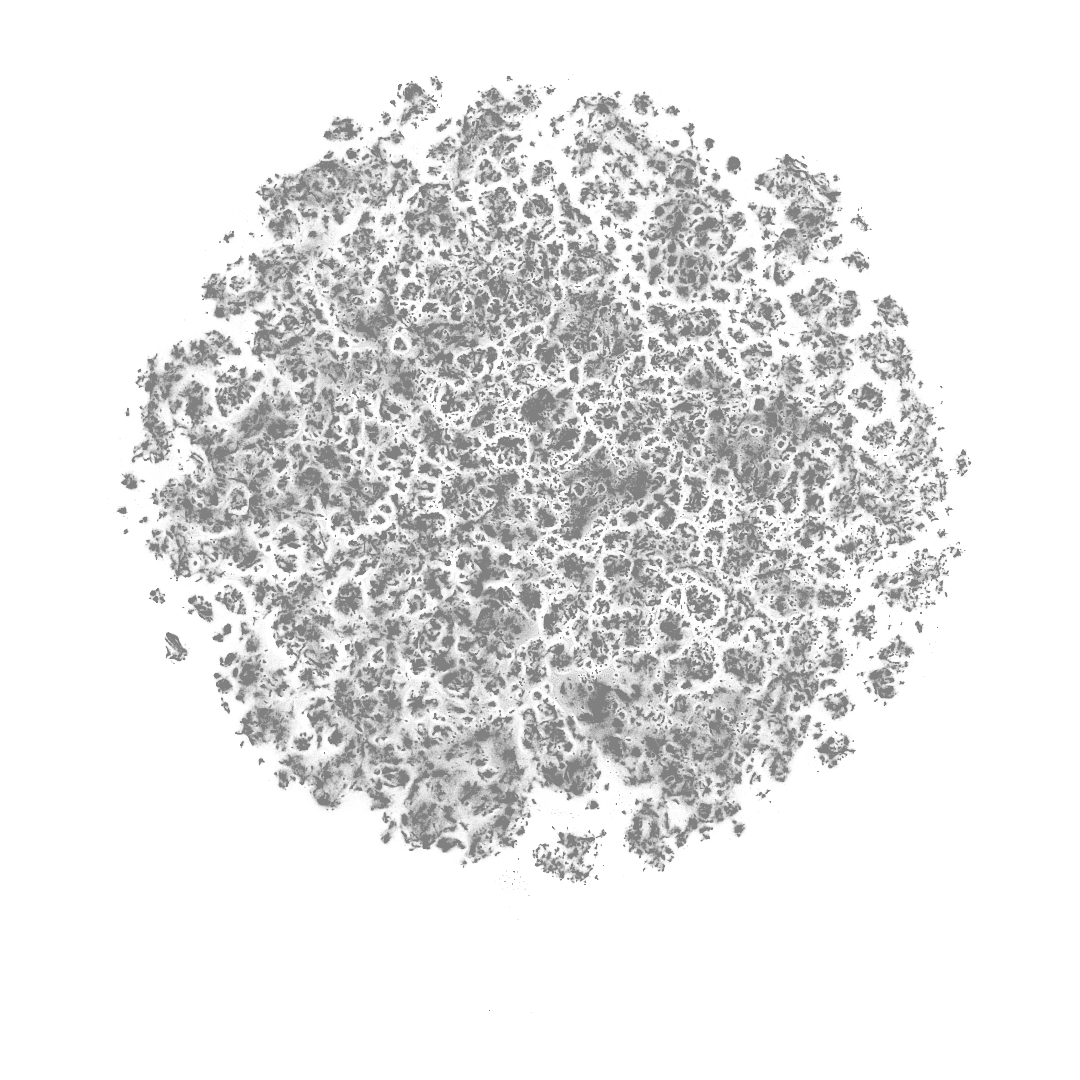

In [18]:
%matplotlib inline 

tsne = tsne_tfidf_reparsed
fig, ax = plt.subplots(figsize=(5.5, 5.5), dpi=200, layout='constrained')

ax.scatter(tsne[:,0], tsne[:,1], s=0.5, c='grey', marker='.', linewidths=None, ec='None', alpha=0.01, rasterized=True)
ax.axis('equal')
ax.xticks([])
ax.yticks([])
ax.axis('off')

plt.savefig(figures_path / "tsne_tfidf_reparsed.png")